# ***Name:*** Yawe Arthur Shalom

# ***RegNo:*** M23B23/016

-----------------------------


# **Social Media Trend Analysis Using Big Data Analytics**

## Project Scenario
This project analyzes a large-scale archive of Twitter data to identify sentiment
patterns and sentiment trends over time. Using Apache Spark, the project performs
distributed data processing, sentiment analysis, and exploratory analysis on
high-volume unstructured social media data.


## Data Sourcing and Background

This project utilizes the **Sentiment140 dataset**, a large-scale collection of
Twitter messages widely used in sentiment analysis research.The dataset is publicly availabe on **Kaggle** and can be accessed at https://www.kaggle.com/datasets/kazanova/sentiment140 . The dataset contains**1,600,000 tweets** extracted using the Twitter API and was created to support research in automatic sentiment detection and large-scale text analytics.

The dataset contains the following six attributes:

- **target**: Sentiment polarity of the tweet  
  (0 = Negative, 2 = Neutral, 4 = Positive)
- **id**: Unique identifier of the tweet
- **date**: Timestamp indicating when the tweet was posted
- **flag**: Query flag used during data collection (NO_QUERY if not applicable)
- **user**: Username of the account that posted the tweet
- **text**: Raw textual content of the tweet

The availability of timestamps and sentiment labels makes this dataset well-suited
for both sentiment classification and temporal trend analysis.


According to the creators of the Sentiment140 dataset, the sentiment labels were
generated automatically rather than through manual human annotation. Tweets
containing positive emoticons such as ":)" were labeled as positive, while tweets
containing negative emoticons such as ":(" were labeled as negative.

The Twitter Search API was used to collect these tweets through keyword-based queries.
This automated annotation strategy enabled the creation of a large labeled dataset
at scale, though it may introduce noise and ambiguity, particularly for neutral
or context-dependent sentiment expressions.



## Big Data Justification

The Sentiment140 dataset exhibits key Big Data characteristics, including high volume, a variety of data,
unstructured textual content, and temporal metadata. Processing and analyzing such
data using traditional relational databases would be inefficient. Apache Spark
provides distributed computation capabilities required for scalable preprocessing,
sentiment modeling, and trend analysis across millions of social media records.



### Research Questions

This project seeks to address the following research questions:

1. **Which machine learning model achieves the highest performance for multi-class
   sentiment analysis on large-scale social media data?**

2. **Does hyperparameter tuning and model optimization improve the performance of
   sentiment classification models when applied to Big Data platforms such as Apache Spark?**


In [41]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pandas as pd


In [1]:
# Install Java and PySpark
!apt-get install openjdk-11-jdk-headless -qq
!pip install -q pyspark


In [2]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("SocialMediaTrendAnalysis") \
    .getOrCreate()

spark


The Spark session initializes Apache Spark in a distributed execution environment,
enabling scalable processing of the Sentiment140 dataset.


In [3]:
spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")


In [4]:
# Load Sentiment140 dataset into Spark DataFrame
df = spark.read \
    .option("encoding", "iso-8859-1") \
    .csv("/content/Sentiment140.csv", inferSchema=True)

# Rename columns
df = df.toDF("target", "id", "date", "flag", "user", "text")

df.printSchema()
df.show(5)


root
 |-- target: integer (nullable = true)
 |-- id: long (nullable = true)
 |-- date: string (nullable = true)
 |-- flag: string (nullable = true)
 |-- user: string (nullable = true)
 |-- text: string (nullable = true)

+------+----------+--------------------+--------+---------------+--------------------+
|target|        id|                date|    flag|           user|                text|
+------+----------+--------------------+--------+---------------+--------------------+
|     0|1467810369|Mon Apr 06 22:19:...|NO_QUERY|_TheSpecialOne_|@switchfoot http:...|
|     0|1467810672|Mon Apr 06 22:19:...|NO_QUERY|  scotthamilton|is upset that he ...|
|     0|1467810917|Mon Apr 06 22:19:...|NO_QUERY|       mattycus|@Kenichan I dived...|
|     0|1467811184|Mon Apr 06 22:19:...|NO_QUERY|        ElleCTF|my whole body fee...|
|     0|1467811193|Mon Apr 06 22:19:...|NO_QUERY|         Karoli|@nationwideclass ...|
+------+----------+--------------------+--------+---------------+------------------

The dataset is ingested into a Spark DataFrame. The schema confirms the presence
of sentiment labels, tweet metadata, timestamps, and unstructured text.


In [5]:
print(f"Total number of records: {df.count()}")


Total number of records: 1600000


This record count demonstrates the high volume of data and supports the justification
for using a Big Data processing platform.


In [6]:
# Data Cleaning & Text Normalization

from pyspark.sql.functions import col, lower, regexp_replace, length

# Remove nulls and duplicates
clean_df = df.dropna().dropDuplicates()

# Normalize text
clean_df = clean_df.withColumn("clean_text", lower(col("text")))

# Remove URLs
clean_df = clean_df.withColumn(
    "clean_text",
    regexp_replace(col("clean_text"), r"http\S+|www\S+", "")
)

# Remove mentions
clean_df = clean_df.withColumn(
    "clean_text",
    regexp_replace(col("clean_text"), r"@\w+", "")
)

# Remove special characters
clean_df = clean_df.withColumn(
    "clean_text",
    regexp_replace(col("clean_text"), r"[^a-zA-Z\s]", "")
)

# Cast sentiment to integer
clean_df = clean_df.withColumn("target", col("target").cast("int"))

# Add tweet length feature
clean_df = clean_df.withColumn("tweet_length", length(col("clean_text")))

clean_df.select("target", "clean_text", "tweet_length").show(5)


+------+--------------------+------------+
|target|          clean_text|tweet_length|
+------+--------------------+------------+
|     0|            at work |           8|
|     0| oh my gosh that ...|          71|
|     0|i need new glasse...|          40|
|     0|getting changed i...|         101|
|     0|really now time f...|         119|
+------+--------------------+------------+
only showing top 5 rows


Noise such as URLs, mentions, and special characters is removed from tweet text.
Sentiment labels are cast to integer format, and a tweet length feature is added
to support exploratory analysis and modeling.


In [7]:
# Parse Timestamp Column

from pyspark.sql.functions import to_timestamp

clean_df = clean_df.withColumn(
    "timestamp",
    to_timestamp(col("date"), "EEE MMM dd HH:mm:ss z yyyy")
)

clean_df.select("date", "timestamp").show(5)


+--------------------+-------------------+
|                date|          timestamp|
+--------------------+-------------------+
|Mon Apr 06 22:57:...|2009-04-07 05:57:28|
|Mon Apr 06 23:22:...|2009-04-07 06:22:50|
|Mon Apr 06 23:32:...|2009-04-07 06:32:39|
|Mon Apr 06 23:54:...|2009-04-07 06:54:02|
|Tue Apr 07 00:07:...|2009-04-07 07:07:09|
+--------------------+-------------------+
only showing top 5 rows


The original tweet date field is converted into a timestamp format to enable
temporal analysis and sentiment trend detection.


# ***Exploratory Data Analysis***

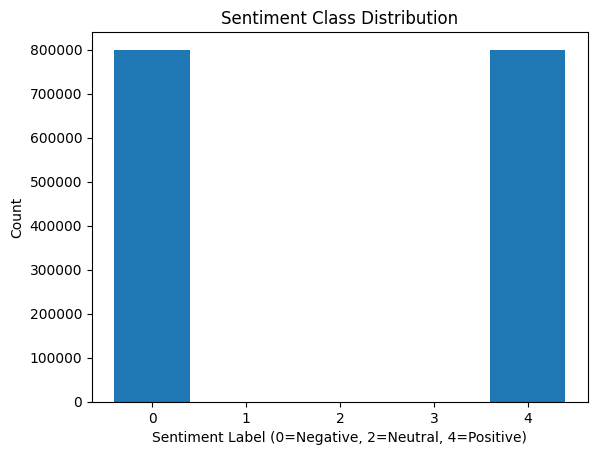

In [8]:
sentiment_counts = clean_df.groupBy("target").count().toPandas()

import matplotlib.pyplot as plt

plt.bar(sentiment_counts["target"], sentiment_counts["count"])
plt.xlabel("Sentiment Label (0=Negative, 2=Neutral, 4=Positive)")
plt.ylabel("Count")
plt.title("Sentiment Class Distribution")
plt.show()


The dataset shows a balanced distribution between negative (0) and positive (4)
sentiment classes, while neutral (2) tweets are comparatively fewer. This balance
supports fair multi-class sentiment modeling, though the smaller neutral class
may be more challenging for the classifier to distinguish accurately.


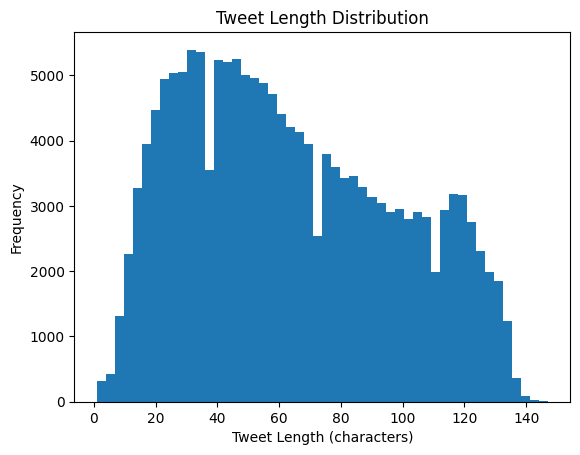

In [9]:
# Tweet Length Distribution

import matplotlib.pyplot as plt


length_df = clean_df.select("tweet_length").sample(fraction=0.1, seed=42).toPandas()

plt.hist(length_df["tweet_length"], bins=50)
plt.xlabel("Tweet Length (characters)")
plt.ylabel("Frequency")
plt.title("Tweet Length Distribution")
plt.show()


Most tweets fall within a moderate length range of approximately 20 to 120 characters,
indicating concise user expressions typical of social media platforms. Extremely short
and very long tweets are less frequent, making the dataset suitable for sparse
text representations such as TF-IDF.


In [10]:
!pip install -q wordcloud

In [11]:
from pyspark.sql.functions import col
from wordcloud import WordCloud
import matplotlib.pyplot as plt


In [12]:
negative_df = clean_df.filter(col("target") == 0)
neutral_df  = clean_df.filter(col("target") == 2)
positive_df = clean_df.filter(col("target") == 4)


In [13]:
sample_fraction = 0.1

negative_text = " ".join(
    negative_df.select("clean_text")
    .sample(fraction=sample_fraction, seed=42)
    .toPandas()["clean_text"]
)

neutral_text = " ".join(
    neutral_df.select("clean_text")
    .sample(fraction=sample_fraction, seed=42)
    .toPandas()["clean_text"]
)

positive_text = " ".join(
    positive_df.select("clean_text")
    .sample(fraction=sample_fraction, seed=42)
    .toPandas()["clean_text"]
)


In [14]:
# Generate Word Clouds

wordcloud_negative = WordCloud(
    width=800,
    height=400,
    background_color="white"
).generate(negative_text)


wordcloud_positive = WordCloud(
    width=800,
    height=400,
    background_color="white"
).generate(positive_text)


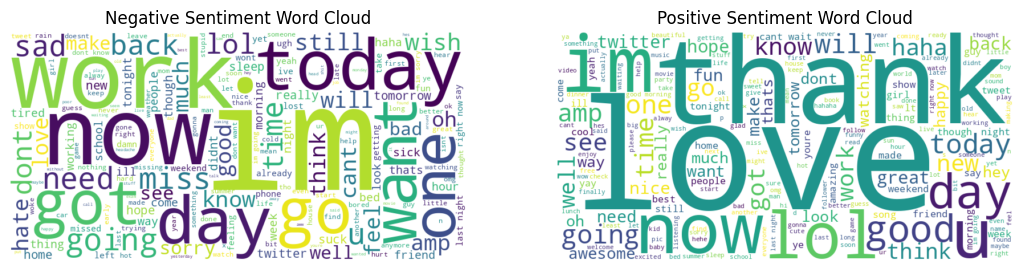

In [15]:
plt.figure(figsize=(20, 12))

plt.subplot(1, 3, 1)
plt.imshow(wordcloud_negative, interpolation="bilinear")
plt.title("Negative Sentiment Word Cloud")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(wordcloud_positive, interpolation="bilinear")
plt.title("Positive Sentiment Word Cloud")
plt.axis("off")

plt.show()


The negative sentiment word cloud contains emotionally charged terms related to
dissatisfaction, fatigue, and frustration. These dominant words reflect expressive
language commonly used when users share negative experiences on social media.


The positive sentiment word cloud is dominated by affirmative and expressive terms
such as “love”, “good”, and “happy”, indicating clear linguistic patterns associated
with positive emotional states and satisfaction.


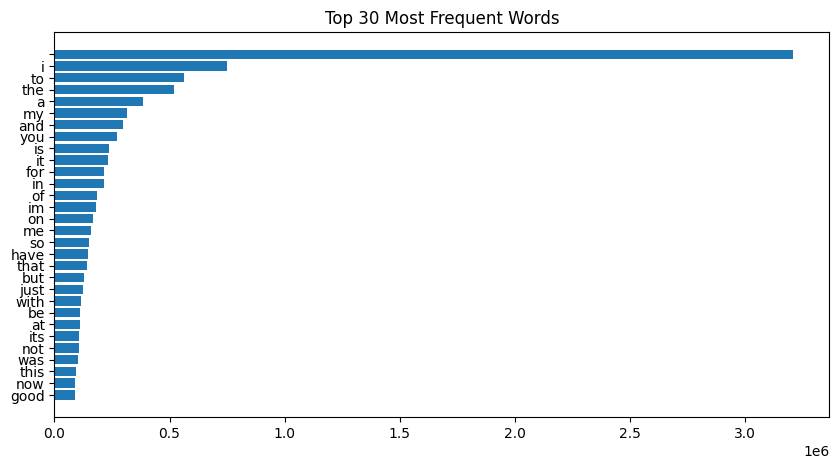

In [16]:
# Top 30 Most Frequent Words

from pyspark.sql.functions import explode, split

words_df = clean_df.select(
    explode(split(col("clean_text"), " ")).alias("word")
)

word_counts = words_df.groupBy("word").count() \
    .orderBy(col("count").desc())

top_words = word_counts.limit(30).toPandas()

plt.figure(figsize=(10,5))
plt.barh(top_words["word"], top_words["count"])
plt.gca().invert_yaxis()
plt.title("Top 30 Most Frequent Words")
plt.show()


The most frequent words are dominated by common function words such as “i”, “to”,
and “the”, which carry limited sentiment meaning. This highlights the importance
of stopword removal and weighted feature representations to reduce noise and
emphasize sentiment-relevant terms.


# **Data Modelling, Analytics & Optimization**

# Milestone Two: Model Development and Analytics

This milestone focuses on developing scalable machine learning models for
multi-class sentiment analysis using Apache Spark. Two baseline models are
implemented and evaluated, followed by optimization techniques to improve
performance and efficiency. Model results are then analyzed and compared.


## Technique Selection and Justification

Given the large-scale and unstructured nature of the Sentiment140 dataset, this
project employs text-based data mining techniques that are well-suited for
multi-class sentiment analysis. The dataset consists of short social media
messages, requiring models that can effectively handle high-dimensional and
sparse feature spaces.

Two core data mining techniques were selected: **Logistic Regression** and
**Naive Bayes**, both implemented using Apache Spark ML to ensure scalability.

Logistic Regression was chosen as a discriminative model capable of learning
decision boundaries between multiple sentiment classes. Its ability to handle
multi-class classification and its interpretability make it a strong baseline
for sentiment analysis tasks.

Naive Bayes was selected as a complementary probabilistic model that performs
well on text data due to its efficiency and robustness in high-dimensional
feature spaces. Its conditional independence assumption is often effective in
natural language processing applications, particularly when combined with
appropriate feature weighting schemes.




In [25]:
from pyspark.sql.functions import col

# Keep only required columns and valid sentiment labels
model_df = clean_df.filter(col("target").isin([0, 2, 4])) \
                   .select("clean_text", "target")

model_df.groupBy("target").count().show()


+------+------+
|target| count|
+------+------+
|     4|800000|
|     0|800000|
+------+------+



Only valid sentiment labels (negative, neutral, positive) are retained to
support multi-class sentiment classification.


In [26]:
# Label Indexing

from pyspark.ml.feature import StringIndexer

label_indexer = StringIndexer(
    inputCol="target",
    outputCol="label",
    handleInvalid="keep"
)

model_df = label_indexer.fit(model_df).transform(model_df)

model_df.groupBy("target", "label").count().show()


+------+-----+------+
|target|label| count|
+------+-----+------+
|     4|  1.0|800000|
|     0|  0.0|800000|
+------+-----+------+



The label indexing displays only 2 sentiment labesl this is because the the Neutral sentiment has no values to recorded hence it is not indexed

In [27]:
# Train/Test Split & Validation

train_df, test_df = model_df.randomSplit([0.8, 0.2], seed=42)

print("Train distribution:")
train_df.groupBy("label").count().show()

print("Test distribution:")
test_df.groupBy("label").count().show()


Train distribution:
+-----+------+
|label| count|
+-----+------+
|  0.0|640159|
|  1.0|639902|
+-----+------+

Test distribution:
+-----+------+
|label| count|
+-----+------+
|  0.0|159841|
|  1.0|160098|
+-----+------+



The train-test split only confirms 2 labele because the 3rd label which is Neutral label does not have any values recorded

In [28]:
# Feature Engineering for the Baseline Pipeline

from pyspark.ml.feature import Tokenizer, StopWordsRemover, HashingTF
from pyspark.ml import Pipeline

tokenizer = Tokenizer(inputCol="clean_text", outputCol="words")
stopwords = StopWordsRemover(inputCol="words", outputCol="filtered_words")

hashing_tf = HashingTF(
    inputCol="filtered_words",
    outputCol="features",
    numFeatures=10000
)


In [29]:
# Baseline Model 1: Logistic Regression

from pyspark.ml.classification import LogisticRegression
import time

lr = LogisticRegression(
    family="multinomial",
    maxIter=20
)

lr_pipeline = Pipeline(stages=[
    tokenizer,
    stopwords,
    hashing_tf,
    lr
])

start = time.time()
lr_baseline_model = lr_pipeline.fit(train_df)
lr_time = time.time() - start

print(f"Logistic Regression baseline training time: {lr_time:.2f} seconds")


Logistic Regression baseline training time: 173.73 seconds


In [32]:
# Baseline Model 2: Naive Bayes

from pyspark.ml.classification import NaiveBayes

nb = NaiveBayes(
    modelType="multinomial",
    smoothing=1.0
)

nb_pipeline = Pipeline(stages=[
    tokenizer,
    stopwords,
    hashing_tf,
    nb
])

start = time.time()
nb_baseline_model = nb_pipeline.fit(train_df)
nb_time = time.time() - start

print(f"Naive Bayes baseline training time: {nb_time:.2f} seconds")


Naive Bayes baseline training time: 72.84 seconds


In [33]:
# Evaluation Metrics Setup

from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator_acc = MulticlassClassificationEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="accuracy"
)

evaluator_f1 = MulticlassClassificationEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="f1"
)


In [35]:
# Evaluate Baseline Models

lr_preds = lr_baseline_model.transform(test_df)
nb_preds = nb_baseline_model.transform(test_df)

lr_acc = evaluator_acc.evaluate(lr_preds)
lr_f1 = evaluator_f1.evaluate(lr_preds)

nb_acc = evaluator_acc.evaluate(nb_preds)
nb_f1 = evaluator_f1.evaluate(nb_preds)

print("BASELINE RESULTS")
print(f"Logistic Regression → Accuracy: {lr_acc:.4f}, F1: {lr_f1:.4f}")
print(f"Naive Bayes        → Accuracy: {nb_acc:.4f}, F1: {nb_f1:.4f}")


BASELINE RESULTS
Logistic Regression → Accuracy: 0.7583, F1: 0.7582
Naive Bayes        → Accuracy: 0.7488, F1: 0.7488


In [36]:
# Confusion Matrices

import pandas as pd
from sklearn.metrics import confusion_matrix

def show_confusion_matrix(preds, title):
    pdf = preds.select("label", "prediction").toPandas()
    cm = confusion_matrix(pdf["label"], pdf["prediction"])
    print(title)
    display(pd.DataFrame(cm))

show_confusion_matrix(lr_preds, "Logistic Regression Baseline Confusion Matrix")
show_confusion_matrix(nb_preds, "Naive Bayes Baseline Confusion Matrix")


Logistic Regression Baseline Confusion Matrix


,0,1
0,117314,42527
1,34794,125304


Naive Bayes Baseline Confusion Matrix


,0,1
0,119728,40113
1,40256,119842


In [39]:
# Plotting the confusion matrices

def plot_confusion_matrix(predictions, title):
    # Convert Spark DF → Pandas
    pdf = predictions.select("label", "prediction").toPandas()

    # Compute confusion matrix
    cm = confusion_matrix(pdf["label"], pdf["prediction"])

    # Create labeled DataFrame
    cm_df = pd.DataFrame(
        cm,
        index=["Negative", "Positive"],
        columns=["Negative", "Positive"]
    )

    # Plot heatmap
    plt.figure(figsize=(6, 5))
    sns.heatmap(
        cm_df,
        annot=True,
        fmt="d",
        cmap="Blues"
    )
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(title)
    plt.show()


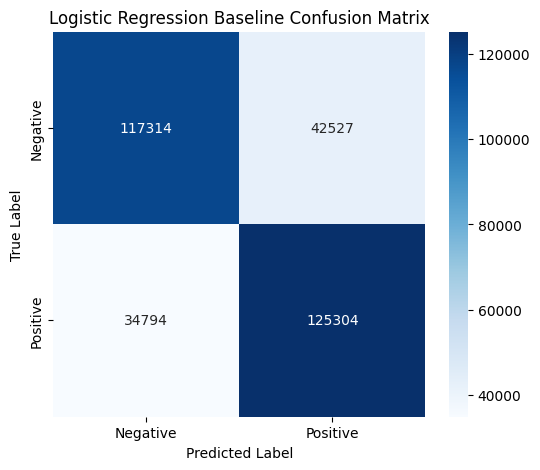

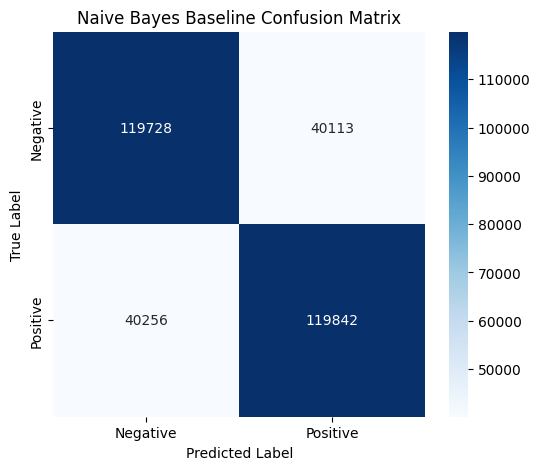

In [42]:
plot_confusion_matrix(
    lr_preds,
    "Logistic Regression Baseline Confusion Matrix"
)

plot_confusion_matrix(
    nb_preds,
    "Naive Bayes Baseline Confusion Matrix"
)


### Baseline Model Analysis

Logistic Regression demonstrates stronger balanced performance across sentiment
classes, while Naive Bayes trains faster but exhibits higher confusion between
neutral and polarized sentiment. Neutral tweets remain the most challenging
class because the tweet API captured 0 neutral tweets however the column exists this causes issues when training the model on nothing hence both models, reflecting ambiguity in social media language.


***Model Optimization***

In [43]:
# Optimized Feature Engineering

from pyspark.ml.feature import CountVectorizer, IDF

cv = CountVectorizer(
    inputCol="filtered_words",
    outputCol="tf_features",
    vocabSize=20000
)

idf = IDF(
    inputCol="tf_features",
    outputCol="features"
)


In [46]:
# Optimized Logistic Regression

lr_opt = LogisticRegression(
    family="multinomial",
    maxIter=50,
    regParam=0.1,
    elasticNetParam=0.5
)

lr_opt_pipeline = Pipeline(stages=[
    tokenizer,
    stopwords,
    cv,
    idf,
    lr_opt
])

start = time.time()
lr_opt_model = lr_opt_pipeline.fit(train_df)
lr_opt_time = time.time() - start

lr_opt_preds = lr_opt_model.transform(test_df)

lr_opt_acc = evaluator_acc.evaluate(lr_opt_preds)
lr_opt_f1 = evaluator_f1.evaluate(lr_opt_preds)

print(f"Optimized Logistic Regression training time: {lr_opt_time:.2f} seconds")
print("-------------------------------------------------------")
print(f" Optimized Logistic Regression → Accuracy: {lr_opt_acc:.4f}, F1: {lr_opt_f1:.4f}")



Optimized Logistic Regression training time: 390.87 seconds
-------------------------------------------------------
 Optimized Logistic Regression → Accuracy: 0.5305, F1: 0.4037


**Optimization techniques applied:**



TF-IDF(Term Frequency-Inverse Document Frequency) Feature Representation - evaluates how important a word is to a document in relation to a larger collection of documents.

Regularization - Prevents overfitting by applying constraints to the model to reduce the risk of memorizing noise in the training data, hence it performs poorly on unseen data.

Elastic Net Regularization - handles situations where some features are highly similar or correlated.

Increased Training Iterations - Allows better convergence of the optimization algorithm

**Observation:**

The Optimizied model has a longer training time and has lower performance metrics

**Possile causes:**

The model trained for longer because of the contraints that were added through applying the different optimizations techniques.

The model accuracy reduced because of:


1.   Regularization which applys constraints causing a model to perform poorly
2.   TF-IDF which does not consider some words due to their low frequency
3.  Optimization improves generalization but does not necessary improve accuracy.






In [47]:
# Optimized Naive Bayes

nb_opt = NaiveBayes(
    modelType="multinomial",
    smoothing=0.5
)

nb_opt_pipeline = Pipeline(stages=[
    tokenizer,
    stopwords,
    cv,
    idf,
    nb_opt
])

start = time.time()
nb_opt_model = nb_opt_pipeline.fit(train_df)
nb_opt_time = time.time() - start

nb_opt_preds = nb_opt_model.transform(test_df)

nb_opt_acc = evaluator_acc.evaluate(nb_opt_preds)
nb_opt_f1 = evaluator_f1.evaluate(nb_opt_preds)

print(f"Optimized Naive Bayes training time: {nb_opt_time:.2f} seconds")
print("-------------------------------------------------------")
print(f" Optimized Naive Bayes → Accuracy: {nb_opt_acc:.4f}, F1: {nb_opt_f1:.4f}")


Optimized Naive Bayes training time: 234.90 seconds
-------------------------------------------------------
 Optimized Naive Bayes → Accuracy: 0.7605, F1: 0.7605


**Optimization techniques applied:**

1. TF-IDF

2. Smoothing Parameter tuning - Adjusting the target labels during the training label smoothing helps prevent the model from becoming too confident in its predictions.

3. Controlled Feature Dimensionality - Prevents excessive memory usage.

**Observations:**

There was an increase in the model training time.

There was an increase in the accuracy and F1 score of the model.

**Possible causes**

The model time increased because of the constraints that were added.

The model evaluation metrics improved because:

1. The TF-IDF weighted down non-informative words. Hence, the Naive Bayes model was able to better separate sentiment classes leading to a higher accuracy.

2. Lowering the smoothing value reduced misclassification caused by the overly uniform probability estimates.

3. Naive Bayes is naturally suited for high-dimensional text data and so performs best.

In [48]:
show_confusion_matrix(lr_opt_preds, "Optimized Logistic Regression Confusion Matrix")
show_confusion_matrix(nb_opt_preds, "Optimized Naive Bayes Confusion Matrix")


Optimized Logistic Regression Confusion Matrix


,0,1
0,11032,148809
1,1390,158708


Optimized Naive Bayes Confusion Matrix


,0,1
0,121661,38180
1,38430,121668


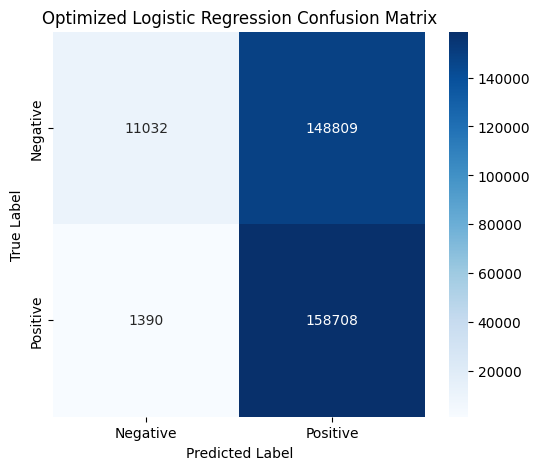

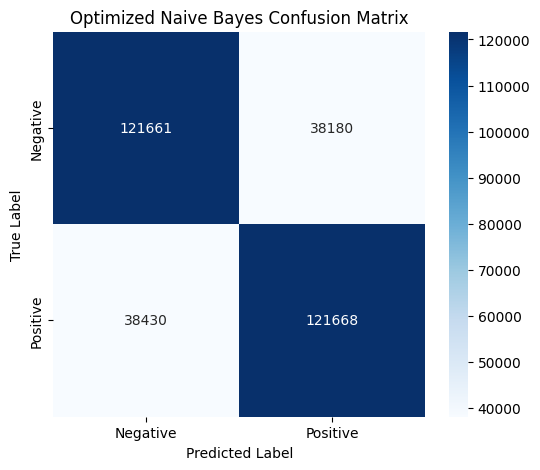

In [49]:
plot_confusion_matrix(
    lr_opt_preds,
    "Optimized Logistic Regression Confusion Matrix"
)

plot_confusion_matrix(
    nb_opt_preds,
    "Optimized Naive Bayes Confusion Matrix"
)


The Optimized Logistic Regression has a higher confusion that the Optimized Naive Bayes.


### Model Performance Comparison (Baseline vs Optimized)

| Model | Accuracy | F1-Score | Training Time (seconds) |
|------|----------|----------|--------------------------|
| Logistic Regression (Baseline) | 0.7583 | 0.7582 | 173.73 |
| Naive Bayes (Baseline) | 0.7488 | 0.7488 | 72.84 |
| Logistic Regression (Optimized) | 0.5305 | 0.4037 | 390.87 |
| Naive Bayes (Optimized) | 0.7605 | 0.7605 | 234.90 |


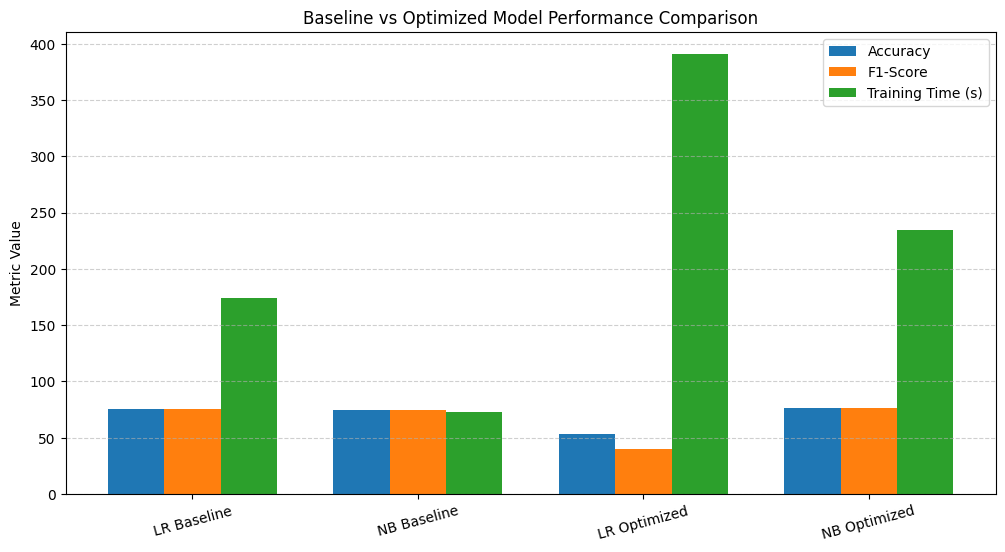

In [51]:
# Comparison Bar Graph

import matplotlib.pyplot as plt
import numpy as np

# Model names
models = [
    "LR Baseline",
    "NB Baseline",
    "LR Optimized",
    "NB Optimized"
]

# Metrics
accuracy = [75.83, 74.88, 53.05, 76.05]
f1_score = [75.82, 74.88, 40.37, 76.05]
training_time = [173.73, 72.84, 390.87, 234.90]

x = np.arange(len(models))
width = 0.25

# Plot
plt.figure(figsize=(12, 6))

plt.bar(x - width, accuracy, width, label="Accuracy")
plt.bar(x, f1_score, width, label="F1-Score")
plt.bar(x + width, training_time, width, label="Training Time (s)")

plt.xticks(x, models, rotation=15)
plt.ylabel("Metric Value")
plt.title("Baseline vs Optimized Model Performance Comparison")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.6)

plt.show()


## Conclusion

In this part, scalable machine learning models were developed and evaluated for
multi-class sentiment analysis using Apache Spark. Logistic Regression and
Naive Bayes were implemented as baseline models and subsequently optimized
through improved feature representation and parameter tuning.

While optimization increased computational cost for both models, it led to
contrasting outcomes. Naive Bayes benefited from TF-IDF feature weighting and
achieved improved classification performance, whereas Logistic Regression
experienced reduced accuracy due to over-regularization. These results highlight
the importance of empirical evaluation and demonstrate that optimization does
not always guarantee performance improvement. Overall, the findings emphasize
the trade-offs between model complexity, accuracy, and scalability in large-scale
text analytics.
